In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
sc.settings.set_figure_params(dpi=100)

In [2]:
# read in the levenshtein distance for the epitope information
df_l = pd.read_csv('../outputs/model_v3/full.epitope.levenshtein.csv', index_col=0)

[Text(0.5, 0, 'Levenshtein Distance'), Text(0, 0.5, 'Count')]

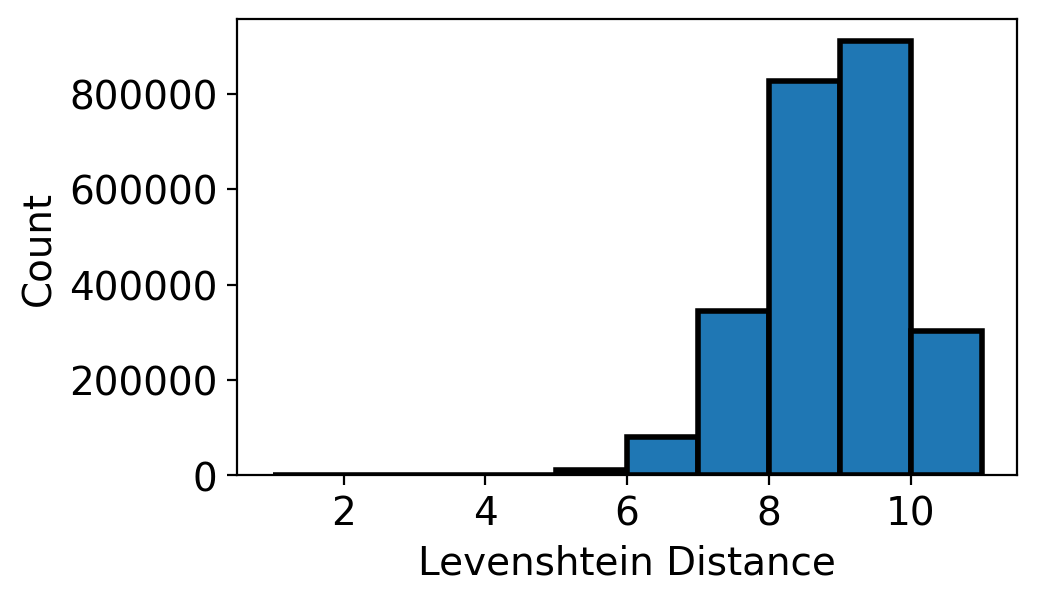

In [3]:
# check the levenshtein distance
fig, ax = plt.subplots(figsize=[5, 3])
ax.grid(False)
ax.hist(df_l.values.flatten()[df_l.values.flatten() > 0], linewidth=2, edgecolor='k', width=1)
ax.set(xlabel='Levenshtein Distance', ylabel='Count')

In [4]:
# read in the values
cdr3_to_X = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
ag_to_X = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)

In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve, auc, accuracy_score
from tqdm import tqdm

%load_ext tensorboard

2024-01-03 14:32:28.135158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 14:32:28.279462: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 14:32:28.941793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-03 14:32:28.941902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [ ]:
# check all possible levenshteins
vmax2stats = {}
for vmax in range(5, 12):
    # set seed and identify irrelevant matches
    np.random.seed(0)
    irrs = []

    # read in the input peptide information
    df = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
    counts = df['Epitope'].value_counts()

    for pep in tqdm(df_l.index):
        # gather peptide cdr3 information
        n_cdr3s = counts.loc[pep]
        pep_cdr3s = df.loc[df['Epitope'] == pep, 'CDR3'].unique()
        # we first grab the peptide levenshtein distances
        pep_levenshtein = df_l[pep].sort_values()[::-1]
        # systematically identify negative controls
        irr_cdr3s = []
        # then we look at the max distance, gather those peptides, randomly choose one
        # find associated CDR3s that don't overlap with the current peptide
        irr_peps = pep_levenshtein.index[pep_levenshtein <= vmax]
        # find the irrelevant peptide CDR3s and make sure they don't overlap
        mask = (df['Epitope'].isin(irr_peps)) & (~df['CDR3'].isin(pep_cdr3s))
        if sum(mask) == 0: continue
        # if we have cdr3s then grab them out
        cdr3s = df.loc[mask, 'CDR3']
        # if there are more than we need randomly select
        if len(cdr3s) > n_cdr3s:
            irr_cdr3s = np.random.choice(cdr3s, size=n_cdr3s, replace=False).tolist()
        # otherwise add them all
        else: irr_cdr3s = cdr3s.tolist()
        # compile the full list
        irr = pd.DataFrame(irr_cdr3s, columns=['CDR3'])
        irr['Epitope'] = pep
        irrs.append(irr)

    # we'll read both of these values and the original input and irrelevant tcrs
    hit = df.copy()
    irr = pd.concat(irrs, axis=0).reset_index().iloc[:, 1:]
    print(hit.shape[0], irr.shape[0])
    # now up sample it accordingly
    if irr.shape[0] < hit.shape[0]:
        idxs = np.random.choice(irr.index, size=hit.shape[0], replace=True)
        irr = irr.loc[idxs].reset_index().iloc[:, 1:]

    # retrieve values and aucs
    fprs, tprs, aucs, accs = [], [], [], []

    # complete 10 iterations
    for seed in range(10):
        ## SETUP CONSTANTS
        # grab a subset
        np.random.seed(seed)
        n_rows = hit.shape[0] // 2
        perc_train = 0.75


        ## SEPARATE OUT TRAINING AND TESTING
        # train and test
        # > subset target
        idxs = np.random.choice(hit.index, size=n_rows, replace=False)
        idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
        hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
        # > subset control
        idxs = np.random.choice(irr.index, size=n_rows, replace=False)
        idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
        irr_train, irr_test = irr.loc[idxs], irr.loc[idys]
        # confirm no overlap
        assert not hit_train.index.isin(hit_test.index).all()
        assert not irr_train.index.isin(irr_test.index).all()

        # validation
        # > subset target
        val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
        hit_val = hit.loc[val_idxs]
        # > subset control
        val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
        irr_val = irr.loc[val_idxs]


        ## CONVERT TO CORRECT FORMAT
        # create X for training
        X_train = pd.concat([hit_train, irr_train], axis=0).reset_index().iloc[:, 1:]
        X_train_cdr3s = cdr3_to_X.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
        X_train_epitopes = ag_to_X.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
        # combine
        X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
        X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
        X_train = X_train_cdr3s.join(X_train_epitopes)

        # grab y for training
        y_train = pd.concat([pd.Series(np.ones(hit_train.shape[0])),
                             pd.Series(np.zeros(irr_train.shape[0]))], axis=0).astype(int)
        y_train = y_train.reset_index().iloc[:, 1:][0]

        # confirm the same length
        assert X_train.shape[0] == y_train.shape[0]

        # create X for testing
        X_test = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]
        X_test_cdr3s = cdr3_to_X.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
        X_test_epitopes = ag_to_X.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
        # combine
        X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
        X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
        X_test = X_test_cdr3s.join(X_test_epitopes)

        # grab y for testing
        y_test = pd.concat([pd.Series(np.ones(hit_test.shape[0])),
                             pd.Series(np.zeros(irr_test.shape[0]))], axis=0).astype(int)
        y_test = y_test.reset_index().iloc[:, 1:][0]

        # confirm the same length
        assert X_test.shape[0] == y_test.shape[0]

        # create X for validation
        X_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
        X_val_cdr3s = cdr3_to_X.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
        X_val_epitopes = ag_to_X.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
        # combine
        X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
        X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
        X_val = X_val_cdr3s.join(X_val_epitopes)

        # grab y for validation
        y_val = pd.concat([pd.Series(np.ones(hit_val.shape[0])),
                             pd.Series(np.zeros(irr_val.shape[0]))], axis=0).astype(int)
        y_val = y_val.reset_index().iloc[:, 1:][0]

        # confirm the same length
        assert X_val.shape[0] == y_val.shape[0]

        # remove constant columns
        X_train = X_train.loc[:, X_train.nunique(0) > 1]
        X_train = X_train.loc[:, X_train.sum(0) > 0]
        # read in normalization factors
        means = X_train.mean(0)
        stds = (X_train - means).std(0)
        # subset for relevant columns
        X_train = X_train[means.index]
        X_test = X_test[means.index]
        X_val = X_val[means.index]
        # normalize
        X_train -= means
        X_train /= stds
        X_test -= means
        X_test /= stds
        X_val -= means
        X_val /= stds

        ## SETUP MODEL
        # retrieve the appropriate columns
        cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
        cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

        # determine model parameters
        # > layer for cdr3 alone
        input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
        output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
        # > layer for ag alone
        input_2 = keras.layers.Input(shape=(len(cols_ag)))
        output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
        # > combined layer
        concat_3 = keras.layers.Concatenate()([output_1, output_2])
        output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
        # > final logit softmax layer
        output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
        model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
        # set up the training parameters for the model
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy','AUC'],
        )
        # train the model
        history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                            epochs=10,
                            validation_data=([X_test[cols_cdr3], X_test[cols_ag]], y_test),
                            workers=40, use_multiprocessing=True)

        # testing predictions
        y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                               workers=40, use_multiprocessing=True)[:, 0]
        y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
        y_pred = pd.concat([y_pred, y_val], axis=1)

        # retrieve auc metrics
        fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
        fprs.append(fpr.tolist())
        tprs.append(tpr.tolist())
        aucs.append(auc(fpr, tpr))
        accs.append(accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))

    # create roc auc curve
    fig, ax = plt.subplots(figsize=[4, 4])
    ax.grid(False)
    # track values to compute mean value
    mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
    # plot the individual cv iterations
    for fpr, tpr in zip(fprs, tprs):
        # grab the true positive rate when we interpolate
        mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
    #     # plot on this individual curve
    #     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
    # grab metrics for auc
    mean_auc = np.mean(aucs)
    ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
    # grab metrics for acc
    mean_acc = np.mean(accs)
    ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
    # plot the average iteration
    mean_tpr = np.mean(mean_tprs, axis=0)
    ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
            label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
            r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
    # plot the standard errors (95% CI actually)
    ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
    mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
    mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
    ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
    # plot the random line
    ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
    # add on labels and adjust limits
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    print(np.mean(aucs), np.std(aucs), np.mean(accs), np.std(accs))
    
    # store it up
    vmax2stats[vmax] = fprs, tprs, aucs, accs

100%|███████████████████████████████████████| 1576/1576 [01:01<00:00, 25.64it/s]


127014 24276


2023-12-29 13:06:59.128719: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-12-29 13:06:59.128790: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-12-29 13:06:59.129663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3806 - accuracy: 0.8342 - auc: 0.9008 - val_loss: 0.3369 - val_accuracy: 0.8566 - val_auc: 0.9247
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3209 - accuracy: 0.8631 - auc: 0.9307 - val_loss: 0.3203 - val_accuracy: 0.8675 - val_auc: 0.9319
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2924 - accuracy: 0.8778 - auc: 0.9415 - val_loss: 0.2981 - val_accuracy: 0.8779 - val_auc: 0.9392
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2594 - accuracy: 0.8945 - auc: 0.9527 - val_loss: 0.2798 - val_accuracy: 0.8900 - val_auc: 0.9454
Epoch 5/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2217 - accuracy: 0.9121 - auc: 0.9648 - val_loss: 0.2628 - val_accuracy: 0.9021 - val_auc: 0.9520
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.1850 - accuracy: 0.9280 - auc: 0.975

Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.1869 - accuracy: 0.9256 - auc: 0.9750 - val_loss: 0.2611 - val_accuracy: 0.9033 - val_auc: 0.9550
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.1553 - accuracy: 0.9375 - auc: 0.9830 - val_loss: 0.2521 - val_accuracy: 0.9128 - val_auc: 0.9596
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.1259 - accuracy: 0.9496 - auc: 0.9893 - val_loss: 0.2501 - val_accuracy: 0.9181 - val_auc: 0.9631
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.1020 - accuracy: 0.9608 - auc: 0.9931 - val_loss: 0.2490 - val_accuracy: 0.9189 - val_auc: 0.9653
Epoch 10/10
3970/3970 [==============================] - 8s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3857 - accuracy: 0.8319 - auc: 0.8980 - val_loss: 0.3431 - val_accuracy: 0.8545 - val_auc: 0.9234
Epoch 2/10
2977/2977 [========================

3970/3970 [==============================] - 8s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3851 - accuracy: 0.8324 - auc: 0.8974 - val_loss: 0.3346 - val_accuracy: 0.8585 - val_auc: 0.9246
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3245 - accuracy: 0.8604 - auc: 0.9289 - val_loss: 0.3103 - val_accuracy: 0.8705 - val_auc: 0.9351
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2952 - accuracy: 0.8750 - auc: 0.9403 - val_loss: 0.2956 - val_accuracy: 0.8780 - val_auc: 0.9401
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2612 - accuracy: 0.8931 - auc: 0.9520 - val_loss: 0.2750 - val_accuracy: 0.8886 - val_auc: 0.9465
Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2241 - accuracy: 0.9108 - auc: 0.9640 - val_loss: 0.2633 - val_accuracy: 0.8966 - val_auc: 0.9512
Epoch 6/10
2977/2977 [==============================] - 12

100%|███████████████████████████████████████| 1576/1576 [01:12<00:00, 21.84it/s]


127014 85269
Epoch 1/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5036 - accuracy: 0.7314 - auc: 0.8242 - val_loss: 0.4536 - val_accuracy: 0.7594 - val_auc: 0.8594
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.4380 - accuracy: 0.7716 - auc: 0.8701 - val_loss: 0.4316 - val_accuracy: 0.7758 - val_auc: 0.8733
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.4047 - accuracy: 0.7927 - auc: 0.8905 - val_loss: 0.4104 - val_accuracy: 0.7911 - val_auc: 0.8875
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3656 - accuracy: 0.8168 - auc: 0.9127 - val_loss: 0.3927 - val_accuracy: 0.8064 - val_auc: 0.9006
Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3241 - accuracy: 0.8409 - auc: 0.9328 - val_loss: 0.3840 - val_accuracy: 0.8116 - val_auc: 0.9083
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2836 - accuracy: 0.8638

Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2834 - accuracy: 0.8654 - auc: 0.9497 - val_loss: 0.3950 - val_accuracy: 0.8145 - val_auc: 0.9111
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2464 - accuracy: 0.8873 - auc: 0.9628 - val_loss: 0.4019 - val_accuracy: 0.8179 - val_auc: 0.9121
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2144 - accuracy: 0.9050 - auc: 0.9722 - val_loss: 0.4124 - val_accuracy: 0.8303 - val_auc: 0.9174
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.1869 - accuracy: 0.9190 - auc: 0.9791 - val_loss: 0.4149 - val_accuracy: 0.8363 - val_auc: 0.9189
Epoch 10/10
3970/3970 [==============================] - 8s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.5059 - accuracy: 0.7296 - auc: 0.8215 - val_loss: 0.4518 - val_accuracy: 0.7627 - val_auc: 0.8606
Epoch 2/10
2977/2977 [========================

3970/3970 [==============================] - 8s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.5067 - accuracy: 0.7286 - auc: 0.8207 - val_loss: 0.4526 - val_accuracy: 0.7600 - val_auc: 0.8600
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.4421 - accuracy: 0.7675 - auc: 0.8664 - val_loss: 0.4337 - val_accuracy: 0.7759 - val_auc: 0.8728
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.4105 - accuracy: 0.7875 - auc: 0.8865 - val_loss: 0.4130 - val_accuracy: 0.7888 - val_auc: 0.8868
Epoch 4/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3731 - accuracy: 0.8118 - auc: 0.9084 - val_loss: 0.3963 - val_accuracy: 0.7995 - val_auc: 0.8973
Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3323 - accuracy: 0.8364 - auc: 0.9288 - val_loss: 0.3864 - val_accuracy: 0.8099 - val_auc: 0.9059
Epoch 6/10
2977/2977 [==============================] - 11

100%|███████████████████████████████████████| 1576/1576 [01:12<00:00, 21.68it/s]


127014 117018
Epoch 1/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6126 - accuracy: 0.6243 - auc: 0.6939 - val_loss: 0.5614 - val_accuracy: 0.6812 - val_auc: 0.7636
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5401 - accuracy: 0.6972 - auc: 0.7837 - val_loss: 0.5315 - val_accuracy: 0.7028 - val_auc: 0.7931
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.4930 - accuracy: 0.7374 - auc: 0.8283 - val_loss: 0.5002 - val_accuracy: 0.7320 - val_auc: 0.8237
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.4414 - accuracy: 0.7746 - auc: 0.8681 - val_loss: 0.4747 - val_accuracy: 0.7508 - val_auc: 0.8449
Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3951 - accuracy: 0.8053 - auc: 0.8971 - val_loss: 0.4713 - val_accuracy: 0.7617 - val_auc: 0.8567
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3542 - accuracy: 0.830

Epoch 6/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.3591 - accuracy: 0.8257 - auc: 0.9165 - val_loss: 0.4863 - val_accuracy: 0.7597 - val_auc: 0.8588
Epoch 7/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.3236 - accuracy: 0.8471 - auc: 0.9335 - val_loss: 0.4947 - val_accuracy: 0.7661 - val_auc: 0.8579
Epoch 8/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.2912 - accuracy: 0.8667 - auc: 0.9469 - val_loss: 0.5015 - val_accuracy: 0.7727 - val_auc: 0.8629
Epoch 9/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.2609 - accuracy: 0.8834 - auc: 0.9581 - val_loss: 0.5264 - val_accuracy: 0.7750 - val_auc: 0.8650
Epoch 10/10
3970/3970 [==============================] - 10s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 15s 4ms/step - loss: 0.6119 - accuracy: 0.6206 - auc: 0.6901 - val_loss: 0.5675 - val_accuracy: 0.6714 - val_auc: 0.7585
Epoch 2/10
2977/2977 [=======================

3970/3970 [==============================] - 8s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 15s 5ms/step - loss: 0.6076 - accuracy: 0.6307 - auc: 0.7029 - val_loss: 0.5643 - val_accuracy: 0.6749 - val_auc: 0.7628
Epoch 2/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5393 - accuracy: 0.6968 - auc: 0.7854 - val_loss: 0.5297 - val_accuracy: 0.7037 - val_auc: 0.7954
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4940 - accuracy: 0.7344 - auc: 0.8271 - val_loss: 0.5004 - val_accuracy: 0.7300 - val_auc: 0.8226
Epoch 4/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4439 - accuracy: 0.7719 - auc: 0.8659 - val_loss: 0.4807 - val_accuracy: 0.7512 - val_auc: 0.8443
Epoch 5/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.3960 - accuracy: 0.8036 - auc: 0.8961 - val_loss: 0.4835 - val_accuracy: 0.7571 - val_auc: 0.8517
Epoch 6/10
2977/2977 [==============================] - 14

100%|███████████████████████████████████████| 1576/1576 [00:58<00:00, 26.94it/s]


127014 127014
Epoch 1/10
2977/2977 [==============================] - 16s 5ms/step - loss: 0.6180 - accuracy: 0.6183 - auc: 0.6774 - val_loss: 0.5761 - val_accuracy: 0.6681 - val_auc: 0.7464
Epoch 2/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5582 - accuracy: 0.6859 - auc: 0.7642 - val_loss: 0.5481 - val_accuracy: 0.6897 - val_auc: 0.7734
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5216 - accuracy: 0.7179 - auc: 0.8020 - val_loss: 0.5368 - val_accuracy: 0.7035 - val_auc: 0.7936
Epoch 4/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4842 - accuracy: 0.7470 - auc: 0.8354 - val_loss: 0.5195 - val_accuracy: 0.7214 - val_auc: 0.8085
Epoch 5/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4435 - accuracy: 0.7764 - auc: 0.8663 - val_loss: 0.5145 - val_accuracy: 0.7313 - val_auc: 0.8196
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.4044 - accuracy: 0.799

Epoch 6/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4119 - accuracy: 0.7936 - auc: 0.8857 - val_loss: 0.5076 - val_accuracy: 0.7370 - val_auc: 0.8268
Epoch 7/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.3774 - accuracy: 0.8153 - auc: 0.9058 - val_loss: 0.5278 - val_accuracy: 0.7361 - val_auc: 0.8230
Epoch 8/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.3474 - accuracy: 0.8324 - auc: 0.9213 - val_loss: 0.5314 - val_accuracy: 0.7394 - val_auc: 0.8293
Epoch 9/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.3202 - accuracy: 0.8484 - auc: 0.9343 - val_loss: 0.5564 - val_accuracy: 0.7401 - val_auc: 0.8284
Epoch 10/10
3970/3970 [==============================] - 10s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 15s 5ms/step - loss: 0.6198 - accuracy: 0.6171 - auc: 0.6788 - val_loss: 0.5819 - val_accuracy: 0.6598 - val_auc: 0.7423
Epoch 2/10
2977/2977 [=======================

3970/3970 [==============================] - 9s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 15s 5ms/step - loss: 0.6156 - accuracy: 0.6178 - auc: 0.6792 - val_loss: 0.5826 - val_accuracy: 0.6620 - val_auc: 0.7329
Epoch 2/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5610 - accuracy: 0.6818 - auc: 0.7583 - val_loss: 0.5575 - val_accuracy: 0.6835 - val_auc: 0.7623
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5302 - accuracy: 0.7095 - auc: 0.7922 - val_loss: 0.5399 - val_accuracy: 0.6985 - val_auc: 0.7842
Epoch 4/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.4963 - accuracy: 0.7363 - auc: 0.8251 - val_loss: 0.5258 - val_accuracy: 0.7130 - val_auc: 0.8002
Epoch 5/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4587 - accuracy: 0.7654 - auc: 0.8550 - val_loss: 0.5168 - val_accuracy: 0.7229 - val_auc: 0.8142
Epoch 6/10
2977/2977 [==============================] - 14

100%|███████████████████████████████████████| 1576/1576 [00:57<00:00, 27.35it/s]


127014 127014
Epoch 1/10
2977/2977 [==============================] - 16s 5ms/step - loss: 0.6225 - accuracy: 0.6119 - auc: 0.6725 - val_loss: 0.5804 - val_accuracy: 0.6653 - val_auc: 0.7424
Epoch 2/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5592 - accuracy: 0.6839 - auc: 0.7616 - val_loss: 0.5524 - val_accuracy: 0.6865 - val_auc: 0.7703
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5253 - accuracy: 0.7093 - auc: 0.7961 - val_loss: 0.5338 - val_accuracy: 0.7021 - val_auc: 0.7911
Epoch 4/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4893 - accuracy: 0.7399 - auc: 0.8294 - val_loss: 0.5190 - val_accuracy: 0.7185 - val_auc: 0.8054
Epoch 5/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4504 - accuracy: 0.7688 - auc: 0.8600 - val_loss: 0.5147 - val_accuracy: 0.7261 - val_auc: 0.8154
Epoch 6/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4125 - accuracy: 0.794

Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.4220 - accuracy: 0.7846 - auc: 0.8773 - val_loss: 0.5174 - val_accuracy: 0.7277 - val_auc: 0.8188
Epoch 7/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3877 - accuracy: 0.8073 - auc: 0.8981 - val_loss: 0.5287 - val_accuracy: 0.7283 - val_auc: 0.8189
Epoch 8/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3572 - accuracy: 0.8254 - auc: 0.9153 - val_loss: 0.5431 - val_accuracy: 0.7325 - val_auc: 0.8216
Epoch 9/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3310 - accuracy: 0.8410 - auc: 0.9281 - val_loss: 0.5608 - val_accuracy: 0.7260 - val_auc: 0.8194
Epoch 10/10
3970/3970 [==============================] - 9s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6245 - accuracy: 0.6124 - auc: 0.6708 - val_loss: 0.5798 - val_accuracy: 0.6687 - val_auc: 0.7426
Epoch 2/10
2977/2977 [========================

3970/3970 [==============================] - 9s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6221 - accuracy: 0.6106 - auc: 0.6690 - val_loss: 0.5858 - val_accuracy: 0.6557 - val_auc: 0.7270
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5665 - accuracy: 0.6747 - auc: 0.7514 - val_loss: 0.5612 - val_accuracy: 0.6781 - val_auc: 0.7602
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5335 - accuracy: 0.7055 - auc: 0.7890 - val_loss: 0.5393 - val_accuracy: 0.6996 - val_auc: 0.7823
Epoch 4/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.4977 - accuracy: 0.7342 - auc: 0.8234 - val_loss: 0.5233 - val_accuracy: 0.7150 - val_auc: 0.8016
Epoch 5/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.4596 - accuracy: 0.7636 - auc: 0.8549 - val_loss: 0.5165 - val_accuracy: 0.7262 - val_auc: 0.8128
Epoch 6/10
2977/2977 [==============================] - 13

100%|███████████████████████████████████████| 1576/1576 [01:10<00:00, 22.20it/s]


127014 127014
Epoch 1/10
2977/2977 [==============================] - 15s 5ms/step - loss: 0.6170 - accuracy: 0.6208 - auc: 0.6822 - val_loss: 0.5777 - val_accuracy: 0.6672 - val_auc: 0.7424
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5576 - accuracy: 0.6836 - auc: 0.7635 - val_loss: 0.5547 - val_accuracy: 0.6829 - val_auc: 0.7667
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5235 - accuracy: 0.7123 - auc: 0.7995 - val_loss: 0.5379 - val_accuracy: 0.6984 - val_auc: 0.7892
Epoch 4/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.4871 - accuracy: 0.7408 - auc: 0.8314 - val_loss: 0.5256 - val_accuracy: 0.7115 - val_auc: 0.8043
Epoch 5/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.4483 - accuracy: 0.7675 - auc: 0.8610 - val_loss: 0.5192 - val_accuracy: 0.7250 - val_auc: 0.8121
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.4113 - accuracy: 0.793

Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.4208 - accuracy: 0.7887 - auc: 0.8802 - val_loss: 0.5283 - val_accuracy: 0.7242 - val_auc: 0.8138
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3882 - accuracy: 0.8089 - auc: 0.8996 - val_loss: 0.5411 - val_accuracy: 0.7234 - val_auc: 0.8143
Epoch 8/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3586 - accuracy: 0.8268 - auc: 0.9156 - val_loss: 0.5595 - val_accuracy: 0.7260 - val_auc: 0.8152
Epoch 9/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3315 - accuracy: 0.8428 - auc: 0.9287 - val_loss: 0.5840 - val_accuracy: 0.7238 - val_auc: 0.8154
Epoch 10/10
3970/3970 [==============================] - 9s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.6216 - accuracy: 0.6134 - auc: 0.6752 - val_loss: 0.5834 - val_accuracy: 0.6599 - val_auc: 0.7378
Epoch 2/10
2977/2977 [========================


KeyboardInterrupt



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f91defcdc10> (for post_execute):


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f91015ca940>
Traceback (most recent call last):
  File "/home/dchen/anaconda3/envs/base_py38/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


In [ ]:
# save the data
import pickle as pkl
with open('tmp.v2.pkl', 'wb') as f:
    pkl.dump(vmax2stats, f)

In [3]:
# pick up the work
import pickle as pkl
with open('tmp.v2.pkl', 'rb') as f:
    vmax2stats = pkl.load(f)

5 0.9679482396764744 0.001140916805696617 0.9232651518730218 0.0020782730328672777
6 0.9194216641053876 0.0018007170081232099 0.8340686853417733 0.0031944848892128844
7 0.8657520024175094 0.0023305962792540386 0.7786007841655251 0.0033030511691130313
8 0.8238902282141476 0.00266975986744394 0.7350843214133875 0.00411891914320149
9 0.8181049994093572 0.00267763025472874 0.7262522241642653 0.003797758434895544
10 0.8154652907926557 0.002116750268662359 0.725252334388335 0.0027692622132708747
11 0.8113201544988439 0.004760981932899336 0.7214503912954477 0.0045431952380448745


[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

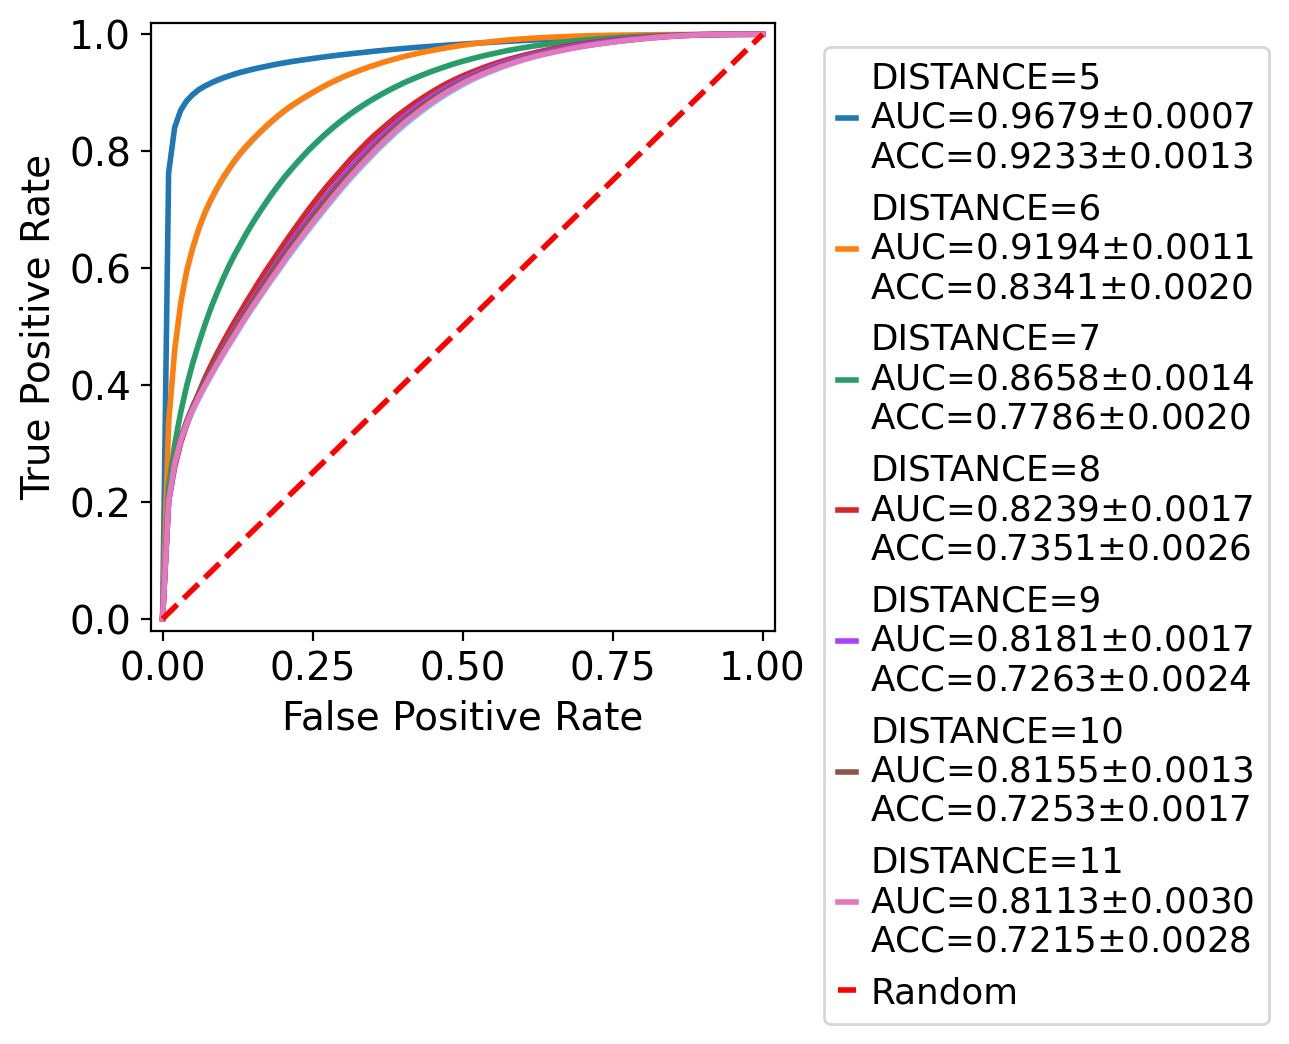

In [4]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
for vmax in range(5, 12):
    # unpack the statistics
    fprs, tprs, aucs, accs = vmax2stats[vmax]
    # track values to compute mean value
    mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
    # plot the individual cv iterations
    for fpr, tpr in zip(fprs, tprs):
        # grab the true positive rate when we interpolate
        mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
    #     # plot on this individual curve
    #     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
    # grab metrics for auc
    mean_auc = np.mean(aucs)
    ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
    # grab metrics for acc
    mean_acc = np.mean(accs)
    ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
    # plot the average iteration
    mean_tpr = np.mean(mean_tprs, axis=0)
    ax.plot(mean_fpr, mean_tpr, linewidth=2,
            label=f'DISTANCE={vmax}\n' + r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
            r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
    # plot the standard errors (95% CI actually)
    ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
    mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
    mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
    ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
    print(vmax, np.mean(aucs), np.std(aucs), np.mean(accs), np.std(accs))
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

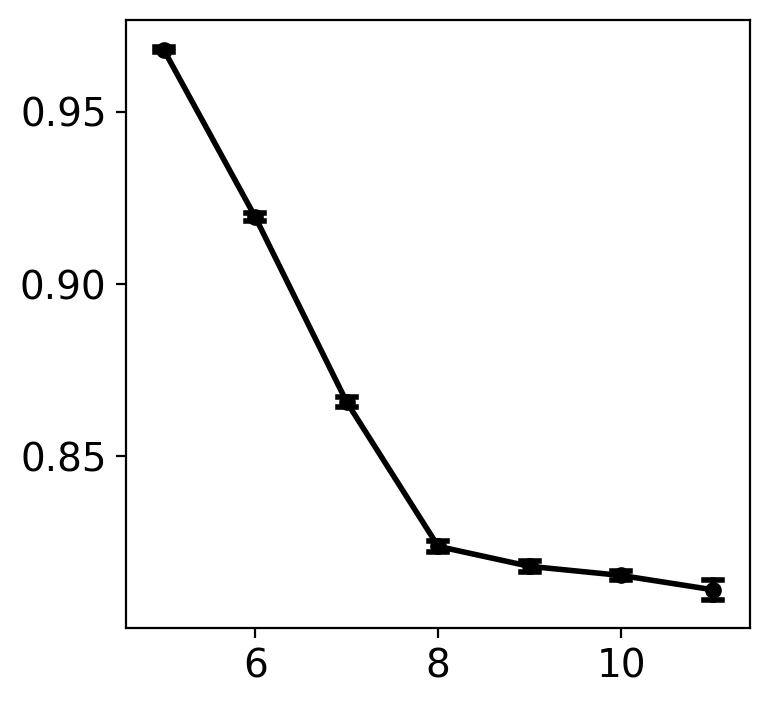

In [4]:
# get the values
xs = list(range(5, 12))
ys_mean = [np.mean(vmax2stats[x][2]) for x in xs]
ys_ci95 = [1.96 * np.std(vmax2stats[x][2]) / np.sqrt(len(vmax2stats[x][2])) for x in xs]
# create the plot
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
ax.scatter(xs, ys_mean, color='k', s=2.5e1)
ax.plot(xs, ys_mean, color='k', lw=2)
# now plot the ci95s
for idx, x in enumerate(xs):
    # retrieve the data
    mean, ci95 = ys_mean[idx], ys_ci95[idx]
    # now plot the ci95
    ax.plot([x]*2, [mean-ci95, mean+ci95], color='k', lw=2)
    ax.plot([x-0.1, x+0.1], [mean-ci95]*2, color='k', lw=2)
    ax.plot([x-0.1, x+0.1], [mean+ci95]*2, color='k', lw=2)